# Analysis of heterophonic pitch synchrony in jingju music

This notebook performs statistical analyses to extract insights about the level of heterophonic pitch synchrony between the vocal melody and the instrumental accompaniment in jingju music. 

Jingju singing is accompanied by an instrumental ensemble in heterophony. Here, the level of heterophonic pitch synchrony is revealed by the distribution of the musical intervals formed between the vocal melody and the lead instrument in the ensemble (jinghu).

These analyses are significantly inspired and use the <a href = " https://compmusic.upf.edu/node/348 ">Jingju Music Scores Collection</a> from: Repetto, R. C., & Serra, X. (2017). <a href = " https://repositori.upf.edu/handle/10230/32603 ">A collection of music scores for corpus based jingju singing research</a>. This collection is part of the corpus gathered in the <a href = " https://compmusic.upf.edu/ ">CompMusic</a> project for jingju music research and offers a comprehensive and complete resource for the study of jingju singing in terms of its musical system.

Note: Each cell begins with a comment that explains what is done in that cell.

In [15]:
# imports 
import csv
import matplotlib.pyplot as plt
import collections
import pandas as pd
import numpy as np

from IPython.display import display
from music21 import *

pd.set_option('display.max_columns', 500)

The next cell defines four different classes that are used to parse the csv files that come with the score collection and to store the intervals provided by the analyses.

The `Score` class has 7 attributes:   
- `title` (in Chinese)
- `couplets`: dictionary with line types as keys and instantiations of the line class as values. 
- `voiceStaves`: staves with lyrics in the collection
- `instrumentalStaves`: staves without lyrics in the collection
- `separatedAccompaniment`: 'yes' or 'no' the original score contained a separated line for the accompaniment.
- `intervalsSS`: intervals that sound simultaneously (instance of the interval class)
- `intervalsPS`: intervals that are played simultaneously (instance of the interval class)

The `Line` class has 6 attributes:
- `shengqiang`
- `banshi`
- `role type`
- `lyrics`
- `startOffset`
- `endOffset`

The `Interval` class is designed to store intervals according to three categories (` shengqiang`, `banshi` and `role type`) which in turn are its attributes.

The `LonelyNotes`class is designed to store the sums of the lengths of the singing notes that do not have a simultaneous instrumental peer. Although its general structure is the same as the `Interval` class, the instantiated object of this class has a different purpose and handling.

In [2]:
# class definitions
class Score:        
    def __init__(self, title):
        self.title = title
        self.couplets = []
        self.voiceStaves = []
        self.instrumentalStaves = []
        self.separatedAccompaniment = ''
        self.intervalsSS = Intervals()
        self.intervalsPS = Intervals()
        self.lonelyNotes = LonelyNotes()
        
    def __str__(self):
        return self.title
    
class Line:
    def __init__(self, shengqiang = '', banshi = '', roleType = '', lyrics = '', startOffset = '', endOffset = ''):
        self.shengqiang = shengqiang
        self.banshi = banshi
        self.roleType = roleType
        self.lyrics  = lyrics
        self.startOffset = startOffset
        self.endOffset = endOffset
        
    def __str__(self):
        return self.lyrics

    
class Intervals:
    def __init__(self):
        self.shengqiang = {}
        self.banshi = {}
        self.roleType = {}

    def __str__(self):
        return 'shengqiang:' + str(self.shengqiang) + ', banshi' + str(self.banshi) + ', roleType' + str(self.roleType)
    
    
class LonelyNotes:
        def __init__(self):
            self.shengqiang = {}
            self.banshi = {}
            self.roleType = {}
            
        def __str__(self):
            return 'shengqiang:' + str(self.shengqiang) + ', banshi' + str(self.banshi) + ', roleType' + str(self.roleType)

In [3]:
# This cell instantiates 92 Score objects when parsing the csv files that come with the score collection
path_folder = './JingjuMusicScoresCollection/MusicXML/'

lines_data_path = path_folder + 'lines_data.csv'
scoreList = [] # Score objects created when parsing the csv file
Couplet = {'openingLine': '', 'kLine': '', 'closingLine': ''}
row_count = 0

with open(lines_data_path, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Store the previous score if a new one is found
        if row[0] != '': # Start of a new score
            if row_count != 0: # Skip the first score
                score.couplets = score_couplets
                scoreList.append(score)
            
            # Updating the score object with a new one
            title = row[0]
            score = Score(title)
            score_couplets = [] # Init the couplet array of the score
        
        if row[1] != '': # important for scores with multiple voice staves
            if Couplet['closingLine'] != '':
                Couplet = {'openingLine': '', 'kLine': '', 'closingLine': ''}

            # Create a new Line object
            line = Line()
            line.roleType = row[1]
            line.shengqiang = row[2]            
            line.banshi = row[3]
            lineType = row[4]
            line.lyrics = row[5]
            line.startOffset = row[6]
            line.endOffset = row[7]

            if lineType.startswith('s'):
                Couplet['openingLine'] = line
            else:
                if lineType.startswith('k'):
                    Couplet['kLine'] = line
                else:
                    Couplet['closingLine'] = line

            # Append the couplet if the current line is a closing line 
            if Couplet['closingLine'] != '':
                score_couplets.append(Couplet)
            
            # Increment the row count
            row_count += 1
    
    # Store the last score
    score.couplets = score_couplets
    scoreList.append(score)
    
print('{} Scores parsed'.format(len(scoreList)))

92 Scores parsed


The scores in the collection have two or three parts. There is no agreement between the original sources about which parts correspond to the voice staves and which parts correspond to the lead instrument. The following cell automatically classifies and keeps track of the vocal parts as those that have lyrics, and the instrumental parts as those that don't.

In [4]:
# classifying and keeping track of parts
for score in scoreList:
    s = converter.parse(path_folder + score.title)

    vocalParts = []
    instrumentalPart = []
    for staff, p in enumerate(s.parts):
        nn = p.flat.notes.stream() # only notes are needed when looking for lyrics
        i = 0
        if len(nn) != 0: # for a special case: lsxp-YiZhuangZhuang-QunYingHui
            n = nn[i]
            while n.quarterLength == 0: # lyrics are only attached to main notes
                i += 1
                n = nn[i]
            if n.lyric != None:
                vocalParts.append(staff)
            else:
                instrumentalPart.append(staff)
        else:
            instrumentalPart.append(staff)
            
    score.voiceStaves = vocalParts
    score.instrumentalStaves = instrumentalPart

# Special cases
# lsxp-YiZhuangZhuang-QunYingHui - the instrumental staff is all silence
# sdxp-DangNianHan-SanJiZhang - there is no have instrumental staff

The score collection transnotations almost always (except for the `sdxp-DangNianHan-SanJiZhang` score) present each voice line and the jinghu line in independent staves. For these analyses, only those scores whose vocal part does not have exactly the same melody as the instrumental part (when there is voice melody) are useful, and in the collection are those whose original scores contain a separate line for the accompaniment.

In the following cell, first the `separatedAccompaniment` attribute of the `Score` objects is set with the appropriate annotation from the `scores_data.csv` file of the collection, and then the `ScoreList` is filtered to consider only these scores.

Of the 92 scores, 53 (57.61 %) of them contain a separate line for the accompaniment.

In [5]:
# filtering scores with separatedAccompaniment

# setting separatedAccompaniment attribute
path_folder = './JingjuMusicScoresCollection/MusicXML/'
lines_data_path = path_folder + 'scores_data.csv'

with open(lines_data_path, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        score = list(filter(lambda x : x.title == row[0]+'.xml', scoreList))[0]
        score.separatedAccompaniment = row[5]
        
filteredScoreList = list(filter(lambda x : x.separatedAccompaniment == 'yes', scoreList))

print('{} filtered scores'.format(len(filteredScoreList)))

53 filtered scores


The following two cells define the functions that compute the number of intervals per type and per category (` shengqiang`, `banshi` and `role type`) in each score. These intervals are store in the `intervalsSS` and `intervalsPS` attributes of the `Score` objects.

The `compIntervalsSS` function deals with the intervals between notes that sound simultaneously, that is to say, intervals formed between each note in the accompaniment and the corresponding sounding note in the singing melody.

The `compIntervalsPS` function deals with the intervals between notes that are played simultaneously, that is to say, intervals formed between the singing and accompaniment notes that are played at the same time.

In [6]:
# computing the number of intervals per type and per category between notes that sound simultaneously
def compIntervalsSS(score):
    path_folder = './JingjuMusicScoresCollection/MusicXML/'
    
    s = converter.parse(path_folder + score.title)

    pi = s.parts[score.instrumentalStaves[0]] # Instrumental part
    ni = pi.flat.notes.stream() # All notes from the instrumental part
        
    for vS in score.voiceStaves:
        pv = s.parts[vS] # Vocal part
        nv = pv.flat.notes.stream() # All notes for the vocal part

        for n1 in ni:
            if n1.quarterLength > 0: # Skip grace notes
                o = n1.offset
                
                flag_found = 0
                for lines in score.couplets:
                    for line in lines.values():
                        if line != '': # skip kLine when it does not exist
                            if o >= float(line.startOffset) and o <= float(eval(line.endOffset)):
                                shengqiang = line.shengqiang
                                banshi = line.banshi
                                roleType = line.roleType
                                flag_found = 1
                                break
                    if flag_found:
                        break
                
                # Retrieve the notes in the vocal part that are sounding at the same time as the instrumental note.
                # The includeEndBoundary option determines if an element begun just at the offsetEnd should be included.
                # The mustBeginInSpan option determines whether notes or other objects that do not begin in the region but are still sounding at the beginning of the region are excluded.
                # Setting includeElementsThatEndAtStart to False is useful for zeroLength searches that set mustBeginInSpan == False to not catch notes that were playing before the search but that end just before the end of the search type.
                nStr = nv.getElementsByOffset(offsetStart = o, 
                                              offsetEnd = o + n1.quarterLength, 
                                              includeEndBoundary = False, 
                                              includeElementsThatEndAtStart = False,
                                              mustBeginInSpan = False).stream()
                for n2 in nStr:
                    if n2.quarterLength > 0: # Skip grace notes
                        itv = interval.Interval(n1, n2)

                        iSSShengqiang = score.intervalsSS.shengqiang # simplified notation with a reference
                        if iSSShengqiang.get(shengqiang) == None: # create if not exist
                            iSSShengqiang[shengqiang] = {} 
                        iSSShengqiang[shengqiang][itv.name] = iSSShengqiang[shengqiang].get(itv.name, 0) + 1

                        iSSBanshi = score.intervalsSS.banshi # simplified notation with a reference
                        if iSSBanshi.get(banshi) == None: # create if not exist
                            iSSBanshi[banshi] = {} 
                        iSSBanshi[banshi][itv.name] = iSSBanshi[banshi].get(itv.name, 0) + 1

                        iSSRoleType = score.intervalsSS.roleType # simplified notation with a reference
                        if iSSRoleType.get(roleType) == None: # create if not exist
                            iSSRoleType[roleType] = {} 
                        iSSRoleType[roleType][itv.name] = iSSRoleType[roleType].get(itv.name, 0) + 1

In [7]:
# computing the number of intervals per type and per category between notes that are played simultaneously
def compIntervalsPS(score):
    path_folder = './JingjuMusicScoresCollection/MusicXML/'
    
    s = converter.parse(path_folder + score.title)

    pi = s.parts[score.instrumentalStaves[0]] # Instrumental part
    ni = pi.flat.notes.stream() # All notes from the instrumental part
        
    for vS in score.voiceStaves:
        pv = s.parts[vS] # Vocal part
        nv = pv.flat.notes.stream() # All notes for the vocal part

        for n1 in ni:
            if n1.quarterLength > 0: # Skip grace notes
                o = n1.offset
                
                flag_found = 0
                for lines in score.couplets:
                    for line in lines.values():
                        if line != '': # skip kLine when it does not exist
                            if o >= float(line.startOffset) and o <= float(eval(line.endOffset)):
                                shengqiang = line.shengqiang
                                banshi = line.banshi
                                roleType = line.roleType
                                flag_found = 1
                                break
                    if flag_found:
                        break
                
                nStr = nv.getElementsByOffset(o).stream()
                for n2 in nStr:
                    if n2.quarterLength > 0: # Skip grace notes
                        itv = interval.Interval(n1, n2)

                        iPSShengqiang = score.intervalsPS.shengqiang # simplified notation with a reference
                        if iPSShengqiang.get(shengqiang) == None: # create if not exist
                            iPSShengqiang[shengqiang] = {} 
                        iPSShengqiang[shengqiang][itv.name] = iPSShengqiang[shengqiang].get(itv.name, 0) + 1

                        iPSBanshi = score.intervalsPS.banshi # simplified notation with a reference
                        if iPSBanshi.get(banshi) == None: # create if not exist
                            iPSBanshi[banshi] = {} 
                        iPSBanshi[banshi][itv.name] = iPSBanshi[banshi].get(itv.name, 0) + 1

                        iPSRoleType = score.intervalsPS.roleType # simplified notation with a reference
                        if iPSRoleType.get(roleType) == None: # create if not exist
                            iPSRoleType[roleType] = {} 
                        iPSRoleType[roleType][itv.name] = iPSRoleType[roleType].get(itv.name, 0) + 1

The following cell defines a function that computes the sum of the lengths of the singing notes that do not have a simultaneous instrumental peer.

In [8]:
def compLonelyNotes(score):
    path_folder = './JingjuMusicScoresCollection/MusicXML/'
    
    s = converter.parse(path_folder + score.title)

    pi = s.parts[score.instrumentalStaves[0]] # Instrumental part
    ni = pi.flat.notes.stream() # All notes from the instrumental part
        
    for vS in score.voiceStaves:
        pv = s.parts[vS] # Vocal part
        nv = pv.flat.notes.stream() # All notes for the vocal part

        for n1 in nv:
            if n1.quarterLength > 0: # Skip grace notes
                o = n1.offset
                
                flag_found = 0
                for lines in score.couplets:
                    for line in lines.values():
                        if line != '': # skip kLine when it does not exist
                            if o >= float(line.startOffset) and o <= float(eval(line.endOffset)):
                                shengqiang = line.shengqiang
                                banshi = line.banshi
                                roleType = line.roleType
                                flag_found = 1
                                break
                    if flag_found:
                        break
                
                lNShengqiang = score.lonelyNotes.shengqiang
                if lNShengqiang.get(shengqiang) == None: # create if not exist
                    lNShengqiang[shengqiang] = [0,0]
                lNShengqiang[shengqiang][1] = lNShengqiang[shengqiang][1] + n1.quarterLength
                
                lNBanshi = score.lonelyNotes.banshi
                if lNBanshi.get(banshi) == None: # create if not exist
                    lNBanshi[banshi] = [0,0]
                lNBanshi[banshi][1] = lNBanshi[banshi][1] + n1.quarterLength
                
                lNRoleType = score.lonelyNotes.roleType
                if lNRoleType.get(roleType) == None: # create if not exist
                    lNRoleType[roleType] = [0,0]
                lNRoleType[roleType][1] = lNRoleType[roleType][1] + n1.quarterLength
                
                nStr = ni.getElementsByOffset(o).stream()
                if len(nStr) == 0:
                    lNShengqiang[shengqiang][0] = lNShengqiang[shengqiang][0] + n1.quarterLength
                    lNBanshi[banshi][0] = lNBanshi[banshi][0] + n1.quarterLength
                    lNRoleType[roleType][0] = lNRoleType[roleType][0] + n1.quarterLength

In [9]:
# applying compIntervals function to the filteredScoreList
for score in filteredScoreList:
    compIntervalsSS(score)
    compIntervalsPS(score)
    compLonelyNotes(score)

In [10]:
# printing the score list
def print_score_list(scoreList):
    print('{} Scores'.format(len(scoreList)))
    for s in scoreList:
        print('Score {} containing {} couplets'.format(s.title, len(s.couplets)))
        print('Voice staves: {}'.format(s.voiceStaves))
        print('Instrumental staves: {}'.format(s.instrumentalStaves))
        print('Separated accompaniment: {}'.format(s.separatedAccompaniment))
        print('IntervalsSS: {}'.format(s.intervalsSS))
        print('IntervalsPS: {}'.format(s.intervalsPS))
        print('Lonely notes: {}'.format(s.lonelyNotes))
        count = 1
        for l in s.couplets:
            print('\tCouplet {}'.format(count))
            print('\tOpening line: {}'.format(l['openingLine']))
            if l['kLine'] != '':
                print('\tK line: {}'.format(l['kLine']))
            print('\tClosing line: {}'.format(l['closingLine']))
            print('\n')
            count += 1

print_score_list(filteredScoreList)

53 Scores
Score daeh-CanQiQi-WuLongZuo.xml containing 2 couplets
Voice staves: [1]
Instrumental staves: [0]
Separated accompaniment: yes
IntervalsSS: shengqiang:{'erhuang': {'P8': 345, 'm7': 40, 'm6': 7, 'P4': 7, 'P1': 35, 'P5': 7, 'M9': 18, 'm3': 6, 'm10': 6, 'M6': 6, 'M2': 3, 'M7': 1, 'P12': 2, 'P11': 2, 'm2': 1, 'M10': 1}}, banshi{'manban': {'P8': 345, 'm7': 40, 'm6': 7, 'P4': 7, 'P1': 35, 'P5': 7, 'M9': 18, 'm3': 6, 'm10': 6, 'M6': 6, 'M2': 3, 'M7': 1, 'P12': 2, 'P11': 2, 'm2': 1, 'M10': 1}}, roleType{'dan': {'P8': 345, 'm7': 40, 'm6': 7, 'P4': 7, 'P1': 35, 'P5': 7, 'M9': 18, 'm3': 6, 'm10': 6, 'M6': 6, 'M2': 3, 'M7': 1, 'P12': 2, 'P11': 2, 'm2': 1, 'M10': 1}}
IntervalsPS: shengqiang:{'erhuang': {'P8': 239, 'P1': 30, 'P5': 2, 'M7': 1, 'm10': 3, 'P11': 1, 'm2': 1, 'M6': 2, 'M10': 1, 'm7': 2, 'M9': 1, 'm3': 1}}, banshi{'manban': {'P8': 239, 'P1': 30, 'P5': 2, 'M7': 1, 'm10': 3, 'P11': 1, 'm2': 1, 'M6': 2, 'M10': 1, 'm7': 2, 'M9': 1, 'm3': 1}}, roleType{'dan': {'P8': 239, 'P1': 30, 'P

	Closing line: 我与你露水的夫妻就过几年（呐）。


	Couplet 10
	Opening line: 是烈女就该在家院，
	Closing line: 为何来在大道边。


	Couplet 11
	Opening line: 为军起下不良的意（呀），
	Closing line: 一马双跨到西凉。


	Couplet 12
	Opening line: 提起了旁人我不晓，
	Closing line: 苏龙魏虎是内亲。


	Couplet 13
	Opening line: 你我同把相府进，
	Closing line: 三人对面（就）说分明。


	Couplet 14
	Opening line: 我父在朝为官宦，
	Closing line: 府内金银堆如山。


	Couplet 15
	Opening line: 本利算来有多少，
	Closing line: 命人送到（那）西凉川。


	Couplet 16
	Opening line: 我进相府对父言，
	Closing line: 家人小厮有万千。


	Couplet 17
	Opening line: 将你带到官衙内，
	Closing line: 打板子、上夹棍、丢南牢、坐监禁、管叫你思前容易退后难。


	Couplet 18
	Opening line: 军爷说话理不端，
	Closing line: 欺奴犹如欺了天。


	Couplet 19
	Opening line: 西凉的鞑子将你斩，
	Closing line: 妻儿老小与奴一般。


	Couplet 20
	Opening line: 这锭银子奴不要，
	Closing line: 与你娘做一个安家钱。


	Couplet 21
	Opening line: 买绫罗、做衣衫、买白纸、糊白幡、打首饰、做妆奁，
	Closing line: 落得个孝子的名儿在那天下传。


Score sdxp-WoHeNi-SiLangTanMu.xml containing 16 couplets
Voice staves: [1, 2]
Instrumental staves: [0]
Separated accompaniment: yes
IntervalsSS: shengqiang:{'xipi': 

The following cell defines a function that sums up the intervals or the lonely notes lengths in a score list inputed in the first argument. The type of abttribute to be summed up in the score list can be set in the `toSumUp` argument.

Since the number of `banshi` in the collection is relatively high (`12`), here the `bashi` are grouped according to their tempo ranges, like this:
- `yuanban`: `yuanban` and `erliu` - 2/4 metre and medium tempo ranges.
- `manban`: `manban`, `sanyan`, `zhongsanyan`, `kuaisanyan` - 4/4 metre and slow tempo.
- `kuaiban`: `kuaiban` and `liushui` - 1/4 metre and fast tempo.

In [11]:
# summing up the intervals in a score list
def sumUp(scoreList, toSumUp = 'intervalsSS'):
    
    # banshi groups
    BGs ={'yuanban':'yuanban', 'erliu':'yuanban',
          'manban': 'manban', 'sanyan': 'manban', 'zhongsanyan': 'manban', 'kuaisanyan': 'manban', 
          'kuaiban': 'kuaiban', 'liushui': 'kuaiban',
          'daoban': '', 'sanban': '', 'yaoban':''} 
  
    if toSumUp == 'intervalsSS' or toSumUp == 'intervalsPS':
        SU = Intervals() # object to store summed up intervals
    elif toSumUp == 'lonelyNotes':
        SU = LonelyNotes() # object to store summed up lengths
    else:
        raise Exception("Invalid attribute")

    for score in scoreList:
        if toSumUp == 'intervalsSS':
            attribute = score.intervalsSS
        elif toSumUp == 'intervalsPS':
            attribute = score.intervalsPS
        else:
            attribute = score.lonelyNotes
        
        if toSumUp == 'intervalsSS' or toSumUp == 'intervalsPS':
            # shengqiang
            for shengqiang, intervals in attribute.shengqiang.items():
                if SU.shengqiang.get(shengqiang) == None: # create shengqiang if not exist
                    SU.shengqiang[shengqiang] = {} 
                for interval, number in intervals.items():                           
                    if SU.shengqiang[shengqiang].get(interval) == None: # assign current number if not exist
                        SU.shengqiang[shengqiang][interval] = number
                    else:
                        SU.shengqiang[shengqiang][interval] += number

            # role type
            for roleType, intervals in attribute.roleType.items():
                if SU.roleType.get(roleType) == None: # create roleType if not exist
                    SU.roleType[roleType] = {} 
                for interval, number in intervals.items():                           
                    if SU.roleType[roleType].get(interval) == None: # assign current number if not exist
                        SU.roleType[roleType][interval] = number
                    else:
                        SU.roleType[roleType][interval] += number

            # banshi
            for banshi, intervals in attribute.banshi.items():
                banshiGroup = BGs[banshi]
                if SU.banshi.get(banshiGroup) == None: # create banshi if not exist
                    SU.banshi[banshiGroup] = {} 
                for interval, number in intervals.items():                           
                    if SU.banshi[banshiGroup].get(interval) == None: # assign current number if not exist
                        SU.banshi[banshiGroup][interval] = number
                    else:
                        SU.banshi[banshiGroup][interval] += number
                        
        else: # Sum of the lengths of singing notes and the lonely notes
            # shengqiang
            for shengqiang, lengths in attribute.shengqiang.items():
                if SU.shengqiang.get(shengqiang) == None: # create shengqiang if not exist
                    SU.shengqiang[shengqiang] = [0,0]
                SU.shengqiang[shengqiang][0] += lengths[0]
                SU.shengqiang[shengqiang][1] += lengths[1]
            
            # role type
            for roleType, lengths in attribute.roleType.items():
                if SU.roleType.get(roleType) == None: # create shengqiang if not exist
                    SU.roleType[roleType] = [0,0] 
                SU.roleType[roleType][0] += lengths[0]
                SU.roleType[roleType][1] += lengths[1]
            
            # banshi
            for banshi, lengths in attribute.banshi.items():
                banshiGroup = BGs[banshi]
                if SU.banshi.get(banshiGroup) == None: # create banshi if not exist
                    SU.banshi[banshiGroup] = [0,0] 
                SU.banshi[banshiGroup][0] += lengths[0]
                SU.banshi[banshiGroup][1] += lengths[1]
             
    return SU

In [12]:
# applying sumUp function to the filteredScoreList
ISS = sumUp(filteredScoreList, toSumUp = 'intervalsSS')
IPS = sumUp(filteredScoreList, toSumUp = 'intervalsPS')
LN = sumUp(filteredScoreList, toSumUp = 'lonelyNotes')

print('Intervals between notes that sound simultaneously\n', ISS, '\n')
print('Intervals between notes that are played simultaneously\n', IPS, '\n')
print('Sums of the lengths of singing notes and the lonely notes\n', LN, '\n')

Intervals between notes that sound simultaneously
 shengqiang:{'erhuang': {'P8': 3792, 'm7': 554, 'm6': 129, 'P4': 211, 'P1': 4528, 'P5': 218, 'M9': 218, 'm3': 430, 'm10': 105, 'M6': 232, 'M2': 946, 'M7': 10, 'P12': 15, 'P11': 15, 'm2': 44, 'M10': 8, 'M3': 126, 'm9': 12, 'A4': 1, 'M13': 1, 'd5': 1}, 'xipi': {'P8': 1822, 'm7': 206, 'P1': 7155, 'm3': 717, 'M9': 90, 'M2': 947, 'm2': 107, 'P5': 93, 'P4': 243, 'M6': 159, 'm10': 66, 'M3': 113, 'm6': 36, 'P11': 22, 'M7': 7, 'm9': 9, 'd5': 1, 'M10': 4, 'm14': 1, 'P15': 1, 'P12': 1, 'm13': 1}}, banshi{'manban': {'P8': 3997, 'm7': 508, 'm6': 122, 'P4': 205, 'P1': 5013, 'P5': 201, 'M9': 229, 'm3': 466, 'm10': 119, 'M6': 257, 'M2': 773, 'M7': 12, 'P12': 16, 'P11': 24, 'm2': 57, 'M10': 7, 'M3': 106, 'm9': 14, 'd5': 2, 'A4': 1, 'M13': 1, 'm14': 1, 'P15': 1, 'm13': 1}, 'yuanban': {'P8': 1291, 'P1': 3744, 'M2': 750, 'M9': 61, 'M6': 100, 'm10': 40, 'm7': 215, 'm6': 34, 'm3': 333, 'P4': 141, 'P5': 89, 'M3': 93, 'm2': 54, 'M10': 3, 'm9': 5, 'P11': 5, 'M7

In [16]:
def sort_intervals_shengqiang(xipi, erhuang):
    # completing dictionaries
    xipi_keys = xipi.keys()
    erhuang_keys = erhuang.keys()

    xipi_completed = xipi.copy()
    erhuang_completed = erhuang.copy()
    for i in xipi_keys:
        try:
            erhuang_completed[i]
        except:
            erhuang_completed[i] = 0
    for i in erhuang_keys:
        try:
            xipi_completed[i]
        except:
            xipi_completed[i] = 0
    
    # sorting dictionaries
    xipi_sorted = collections.OrderedDict()
    erhuang_sorted = collections.OrderedDict()
    
    interval_tuples = []
    for i, interval_name in enumerate(xipi_completed.keys()):
        interval_tuples.append( (interval.Interval(interval_name).semitones,
                                 interval_name,
                                 interval_name[0],
                                 interval_name[1:]) ) 
    sorted_interval_tuples = sorted(interval_tuples, key=lambda x: (x[0], x[3]) )
    
    for i in  sorted_interval_tuples:
        xipi_sorted[i[1]] = xipi_completed[i[1]]
        erhuang_sorted[i[1]] = erhuang_completed[i[1]]
    
    return xipi_sorted, erhuang_sorted


def plot_shengqiang(intervals, plot_title):
    xipi = intervals.shengqiang['xipi']
    erhuang = intervals.shengqiang['erhuang']

    xipi, erhuang = sort_intervals_shengqiang(xipi, erhuang)
    shengqiang_labels = ['xipi', 'erhuang']

    xTicks = xipi.keys()
    xValues = np.arange(len(xipi))
    xValuesX = xValues - 0.2
    xValuesE = xValues + 0.2
    yValuesX = np.array(list(xipi.values())) / np.sum(list(xipi.values())) #/ LN.shengqiang['xipi'][0]
    yValuesE = np.array(list(erhuang.values())) / np.sum(list(erhuang.values())) #/ LN.shengqiang['erhuang'][0]

    plt.figure(figsize=(12,5))
    plt.subplot()
    plt.title(plot_title)
    plt.xticks(xValues, xTicks)
    plt.bar(xValuesX, yValuesX, width = 0.4, color = 'b', align = 'center')
    plt.bar(xValuesE, yValuesE, width = 0.4, color = 'r', align = 'center')
    plt.legend(shengqiang_labels, loc="upper center")
    plt.xlim(-0.5,len(xValuesX)-0.5)
    plt.show()

    df = pd.DataFrame(data=[xipi, erhuang], index=shengqiang_labels)
    display(df)

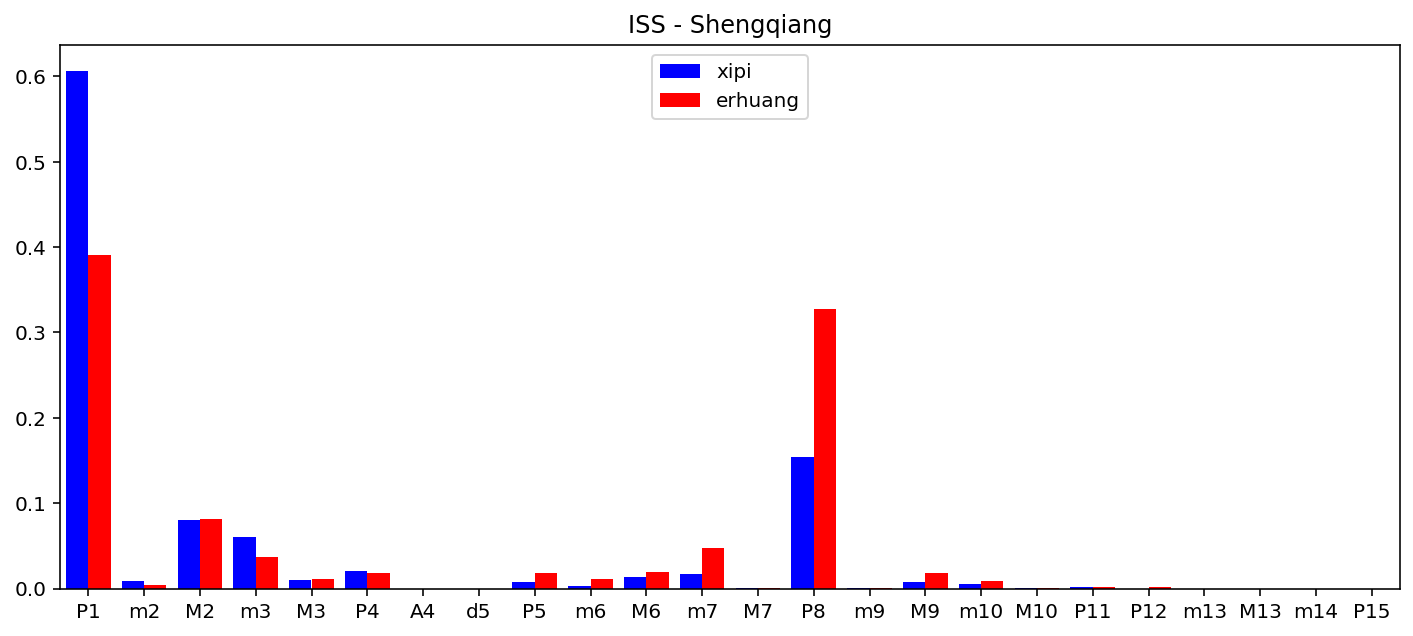

,P1,m2,M2,m3,M3,P4,A4,d5,P5,m6,M6,m7,M7,P8,m9,M9,m10,M10,P11,P12,m13,M13,m14,P15
xipi,7155,107,947,717,113,243,0,1,93,36,159,206,7,1822,9,90,66,4,22,1,1,0,1,1
erhuang,4528,44,946,430,126,211,1,1,218,129,232,554,10,3792,12,218,105,8,15,15,0,1,0,0


In [17]:
# ISS: shengqiang comparative
plot_shengqiang(ISS, 'ISS - Shengqiang')

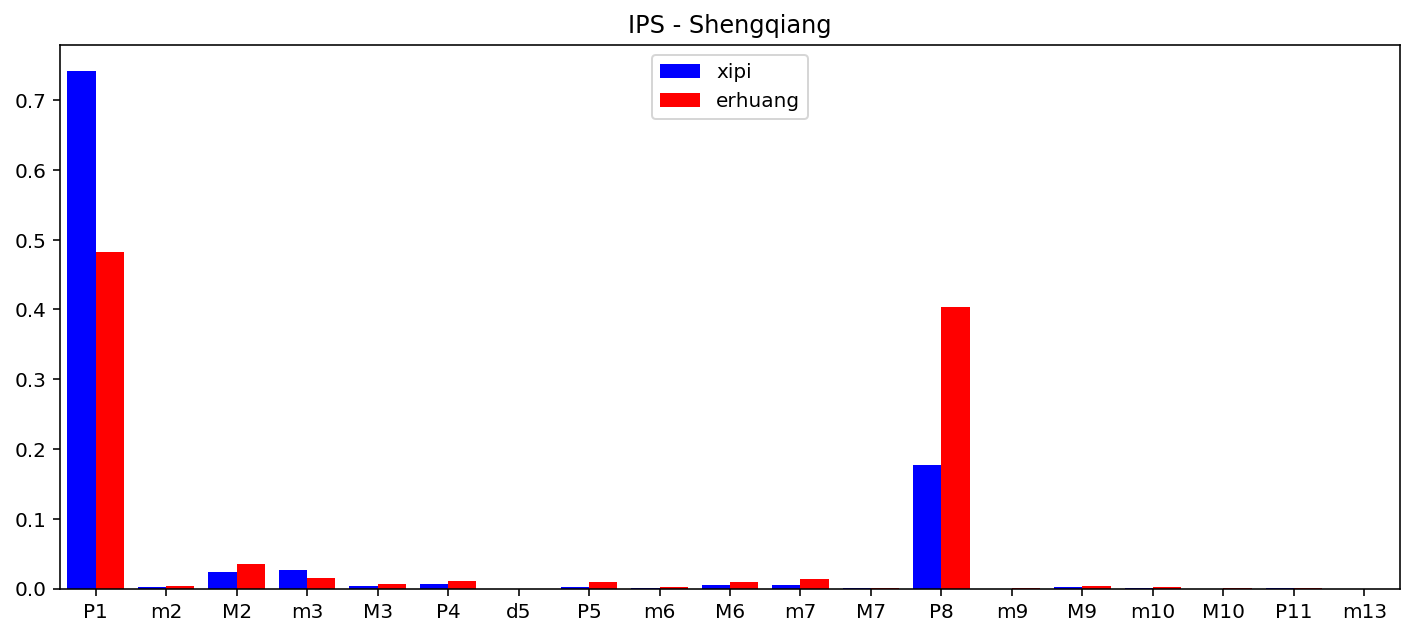

,P1,m2,M2,m3,M3,P4,d5,P5,m6,M6,m7,M7,P8,m9,M9,m10,M10,P11,m13
xipi,6138,22,198,225,29,49,0,23,11,40,43,4,1461,1,18,8,0,3,1
erhuang,3577,25,262,115,52,76,1,66,18,66,98,4,2996,4,32,21,3,3,0


In [18]:
# IPS: Shengqiang comparative
plot_shengqiang(IPS, 'IPS - Shengqiang')

In [19]:
def sort_intervals_banshi(manban, yuanban, kuaiban):
    # completing dictionaries
    manban_keys = manban.keys()
    yuanban_keys = yuanban.keys()
    kuaiban_keys = kuaiban.keys()

    manban_completed = manban.copy()
    yuanban_completed = yuanban.copy()
    kuaiban_completed = kuaiban.copy()
    
    for i in manban_keys:
        try:
            yuanban_completed[i]
        except:
            yuanban_completed[i] = 0
        try:
            kuaiban_completed[i]
        except:
            kuaiban_completed[i] = 0
            
    for i in yuanban_keys:
        try:
            manban_completed[i]
        except:
            manban_completed[i] = 0
        try:
            kuaiban_completed[i]
        except:
            kuaiban_completed[i] = 0
            
    for i in kuaiban_keys:
        try:
            yuanban_completed[i]
        except:
            yuanban_completed[i] = 0
        try:
            manban_completed[i]
        except:
            manban_completed[i] = 0
    
    # sorting dictionaries
    manban_sorted = collections.OrderedDict()
    yuanban_sorted = collections.OrderedDict()
    kuaiban_sorted = collections.OrderedDict()
    
    interval_tuples = []
    for i, interval_name in enumerate(manban_completed.keys()):
        interval_tuples.append( (interval.Interval(interval_name).semitones,
                                 interval_name,
                                 interval_name[0],
                                 interval_name[1:]) ) 
    sorted_interval_tuples = sorted(interval_tuples, key=lambda x: (x[0], x[3]) )
    
    for i in  sorted_interval_tuples:
        manban_sorted[i[1]] = manban_completed[i[1]]
        yuanban_sorted[i[1]] = yuanban_completed[i[1]]
        kuaiban_sorted[i[1]] = kuaiban_completed[i[1]]
        
    return manban_sorted, yuanban_sorted, kuaiban_sorted


def plot_banshi(intervals, plot_title):
    manban = intervals.banshi['manban']
    yuanban = intervals.banshi['yuanban']
    kuaiban = intervals.banshi['kuaiban']
    
    manban, yuanban, kuaiban = sort_intervals_banshi(manban, yuanban, kuaiban)
    banshi_labels = ['manban', 'yuanban', 'kuaiban']

    xTicks = manban.keys()
    xValues = np.arange(len(manban))
    xValuesM = xValues - 0.3
    xValuesY = xValues
    xValuesK = xValues + 0.3
    yValuesM = np.array(list(manban.values())) / np.sum(list(manban.values())) #/ LN.banshi['manban'][0]
    yValuesY = np.array(list(yuanban.values())) / np.sum(list(yuanban.values())) #/ LN.banshi['yuanban'][0]
    yValuesK = np.array(list(kuaiban.values())) / np.sum(list(kuaiban.values())) #/ LN.banshi['kuaiban'][0]

    plt.figure(figsize=(12,5))
    plt.subplot()
    plt.title(plot_title)
    plt.xticks(xValues, xTicks)
    plt.bar(xValuesM, yValuesM, width = 0.3, color = 'b', align = 'center')
    plt.bar(xValuesY, yValuesY, width = 0.3, color = 'r', align = 'center')
    plt.bar(xValuesK, yValuesK, width = 0.3, color = 'g', align = 'center')
    plt.legend(banshi_labels, loc="upper center")
    plt.xlim(-0.5,len(xValuesM)-0.5)
    plt.show()

    df = pd.DataFrame(data=[manban, yuanban, kuaiban], index=banshi_labels)
    display(df)

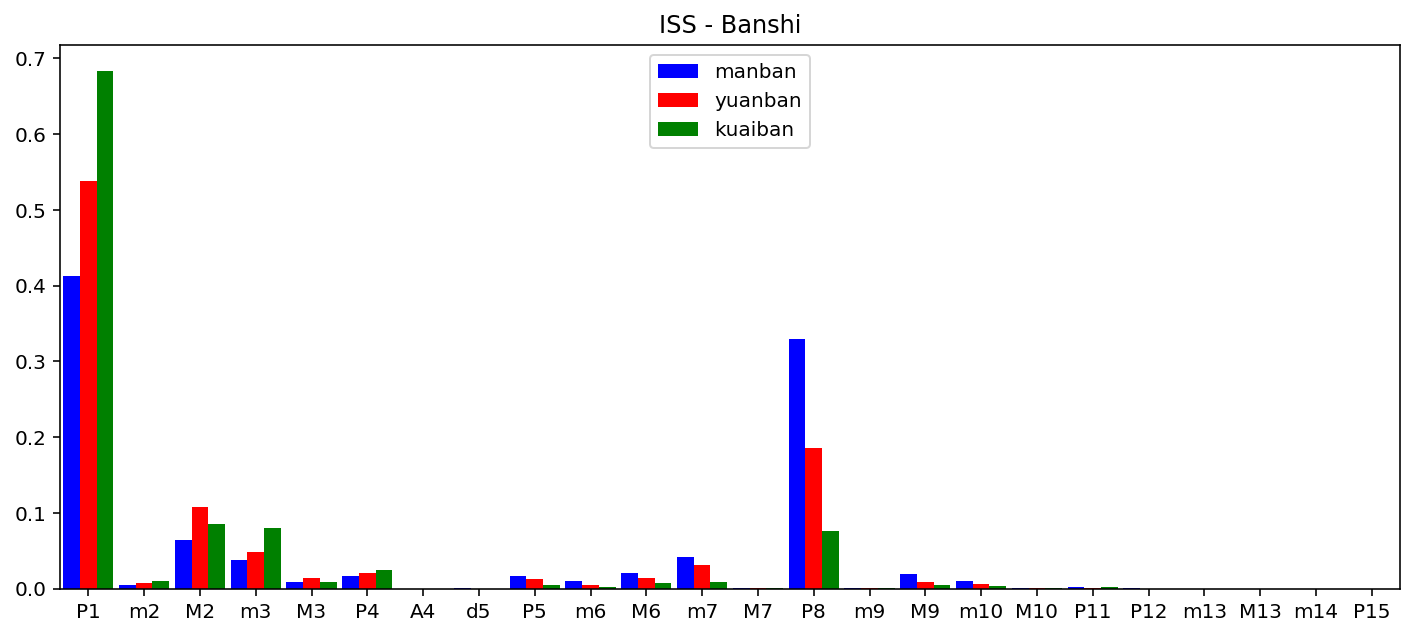

,P1,m2,M2,m3,M3,P4,A4,d5,P5,m6,M6,m7,M7,P8,m9,M9,m10,M10,P11,P12,m13,M13,m14,P15
manban,5013,57,773,466,106,205,1,2,201,122,257,508,12,3997,14,229,119,7,24,16,1,1,1,1
yuanban,3744,54,750,333,93,141,0,0,89,34,100,215,4,1291,5,61,40,3,5,0,0,0,0,0
kuaiban,2915,40,362,339,39,104,0,0,19,8,34,37,1,326,2,18,12,2,8,0,0,0,0,0


In [20]:
# ISS: banshi comparative
plot_banshi(ISS, 'ISS - Banshi')

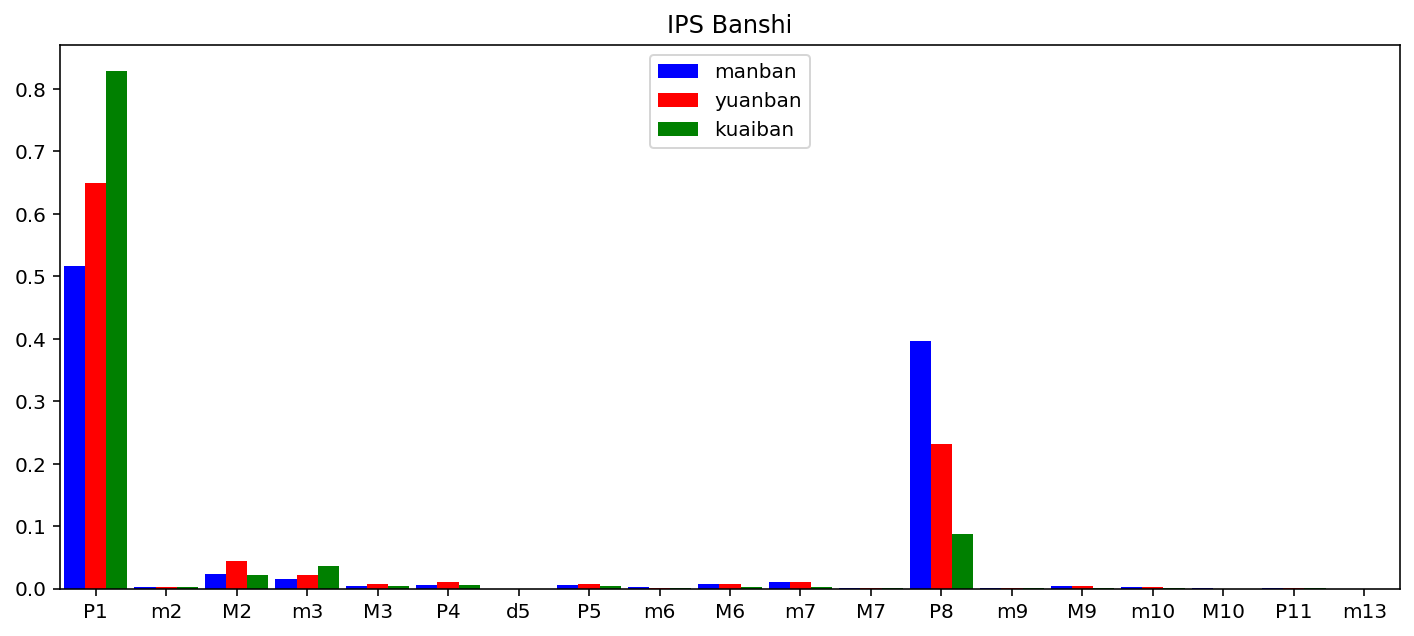

,P1,m2,M2,m3,M3,P4,d5,P5,m6,M6,m7,M7,P8,m9,M9,m10,M10,P11,m13
manban,4029,26,181,115,38,50,1,39,24,61,87,6,3102,2,28,17,3,3,1
yuanban,3002,13,203,101,32,52,0,34,2,36,48,1,1072,2,18,11,0,1,0
kuaiban,2677,8,72,119,11,21,0,14,2,9,6,1,283,1,4,1,0,2,0


In [21]:
# IPS: banshi comparative
plot_banshi(IPS, 'IPS Banshi')

In [24]:
def sort_intervals_roleType(laosheng, dan):
    # completing dictionaries
    laosheng_keys = laosheng.keys()
    dan_keys = dan.keys()

    laosheng_completed = laosheng.copy()
    dan_completed = dan.copy()
    for i in laosheng_keys:
        try:
            dan_completed[i]
        except:
            dan_completed[i] = 0
    for i in dan_keys:
        try:
            laosheng_completed[i]
        except:
            laosheng_completed[i] = 0
    
    # sorting dictionaries
    laosheng_sorted = collections.OrderedDict()
    dan_sorted = collections.OrderedDict()
    
    interval_tuples = []
    for i, interval_name in enumerate(laosheng_completed.keys()):
        interval_tuples.append( (interval.Interval(interval_name).semitones,
                                 interval_name,
                                 interval_name[0],
                                 interval_name[1:]) ) 
    sorted_interval_tuples = sorted(interval_tuples, key=lambda x: (x[0], x[3]) )
    
    for i in  sorted_interval_tuples:
        laosheng_sorted[i[1]] = laosheng_completed[i[1]]
        dan_sorted[i[1]] = dan_completed[i[1]]
    
    return laosheng_sorted, dan_sorted


def plot_roleType(intervals, plot_title):
    laosheng = intervals.roleType['laosheng']
    dan = intervals.roleType['dan']

    laosheng, dan = sort_intervals_roleType(laosheng, dan)
    roleType_labels = ['laosheng', 'dan']

    xTicks = laosheng.keys()
    xValues = np.arange(len(laosheng))
    xValuesL = xValues - 0.2
    xValuesD = xValues + 0.2
    yValuesL = np.array(list(laosheng.values())) / np.sum(list(laosheng.values())) #/ LN.roleType['laosheng'][0]
    yValuesD = np.array(list(dan.values())) / np.sum(list(dan.values())) #/ LN.roleType['dan'][0]

    plt.figure(figsize=(12,5))
    plt.subplot()
    plt.title(plot_title)
    plt.xticks(xValues, xTicks)
    plt.bar(xValuesL, yValuesL, width = 0.4, color = 'b', align = 'center')
    plt.bar(xValuesD, yValuesD, width = 0.4, color = 'r', align = 'center')
    plt.legend(roleType_labels, loc="upper center")
    plt.xlim(-0.5,len(xValuesL)-0.5)
    plt.show()

    df = pd.DataFrame(data=[laosheng, dan], index=roleType_labels)
    display(df)

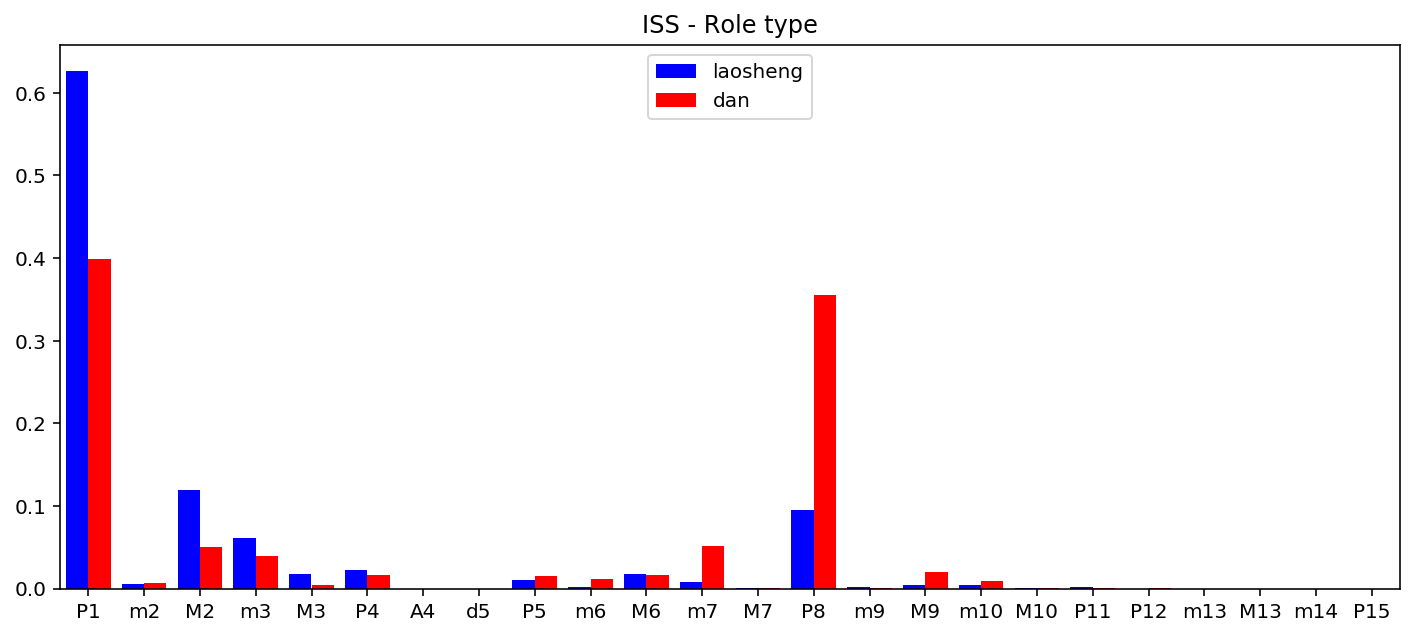

,P1,m2,M2,m3,M3,P4,A4,d5,P5,m6,M6,m7,M7,P8,m9,M9,m10,M10,P11,P12,m13,M13,m14,P15
laosheng,6389,59,1219,622,175,235,0,0,107,17,179,86,3,968,14,47,50,4,22,1,1,0,1,1
dan,5217,91,657,516,64,213,1,1,201,148,211,674,14,4640,7,261,121,8,15,15,0,1,0,0


In [25]:
# ISS: Role type comparative
plot_roleType(ISS, 'ISS - Role type')

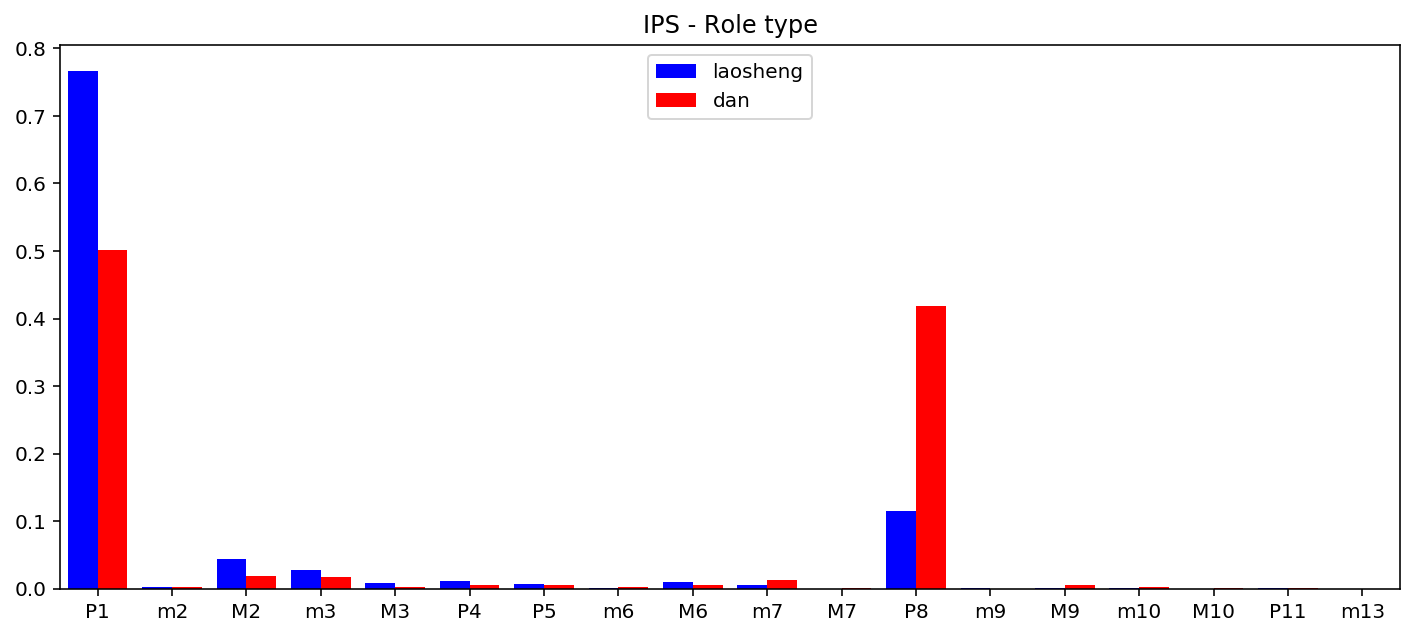

,P1,m2,M2,m3,M3,P4,P5,m6,M6,m7,M7,P8,m9,M9,m10,M10,P11,m13
laosheng,5264,19,296,190,60,75,43,11,63,35,1,789,4,8,3,0,3,1
dan,4386,27,160,147,21,44,45,18,42,106,7,3664,1,42,26,3,3,0


In [26]:
# IPS: Role type comparative
plot_roleType(IPS, 'IPS - Role type')

In [43]:
def get_LN_ratio(attribute, name):
    singing = attribute[name][0]
    lonely = attribute[name][1]
    ratio = singing / lonely
    data = {'Singing notes': round(singing, 3), 'Lonely notes': round(lonely, 3), 'Ratio': round(ratio, 3)}
    return data

In [44]:
# Shengqiang: Singing notes vs Lonely notes
erhuang_data = get_LN_ratio(LN.shengqiang, 'erhuang')
xipi_data = get_LN_ratio(LN.shengqiang, 'xipi')

df = pd.DataFrame(data=[erhuang_data, xipi_data], index=['erhuang', 'xipi'])
display(df)

,Singing notes,Lonely notes,Ratio
erhuang,150.208,3595.625,0.042
xipi,266.312,4695.125,0.057


In [45]:
# Banshi: Singing notes vs Lonely notes
manban_data = get_LN_ratio(LN.banshi, 'manban')
yuanban_data = get_LN_ratio(LN.banshi, 'yuanban')
kuaiban_data = get_LN_ratio(LN.banshi, 'kuaiban')

df = pd.DataFrame(data=[manban_data, yuanban_data, kuaiban_data], index=['manban', 'yuanban', 'kuaiban'])
display(df)

,Singing notes,Lonely notes,Ratio
manban,69.771,3734.250,0.019
yuanban,70.125,2441.625,0.029
kuaiban,39.625,1858.375,0.021


In [46]:
# Role type: Singing notes vs Lonely notes
dan_data = get_LN_ratio(LN.roleType, 'dan')
laosheng_data = get_LN_ratio(LN.roleType, 'laosheng')

df = pd.DataFrame(data=[dan_data, laosheng_data], index=['dan', 'laosheng'])
display(df)

,Singing notes,Lonely notes,Ratio
dan,107.979,4037.625,0.027
laosheng,308.542,4214.625,0.073
